In [1]:
!pip install torchaudio-augmentations
!pip install audio_augmentations

import torch
import torchaudio
import torchtext
import torchaudio.functional as F
import torchaudio.transforms as T
from audio_augmentations import *

import os, re, random
import numpy as np
import sklearn
import itertools
import time

import pickle
from tqdm.auto import tqdm
from IPython.display import clear_output
import IPython.display as ipd
import gc
import matplotlib.pyplot as plt
import wandb

print(torch.__version__)
print(torchaudio.__version__)

import sys
sys.path.append('/kaggle/working/Voice-commands-recognition')
sys.path.append('/kaggle/working/Voice-commands-recognition/notebooks')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21895 sha256=160a318a77930332192507b03f5bcd8a823f6f790c8d0fb0eb8d1cfcde60bebe
  Stored in directory: /root/.cache/pip/wheels/51/9b/56/88fb93285c14b8f93a150285d6ee50c25715b46d79552f84ea
Successfully built julius


[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


1.13.0
0.13.0


In [2]:
# !rm -rf ./Voice-commands-recognition
!git clone https://github.com/litvan007/Voice-commands-recognition.git
!mkdir /kaggle/working/Voice-commands-recognition/notebooks/signal_plots
!mkdir /kaggle/working/Voice-commands-recognition/notebooks/spec_plots
!mkdir /kaggle/working/Voice-commands-recognition/notebooks/mfcc_plots
!mkdir /kaggle/working/Voice-commands-recognition/checkpoints

fatal: destination path 'Voice-commands-recognition' already exists and is not an empty directory.
mkdir: cannot create directory ‘/kaggle/working/Voice-commands-recognition/notebooks/signal_plots’: File exists
mkdir: cannot create directory ‘/kaggle/working/Voice-commands-recognition/notebooks/spec_plots’: File exists
mkdir: cannot create directory ‘/kaggle/working/Voice-commands-recognition/notebooks/mfcc_plots’: File exists
mkdir: cannot create directory ‘/kaggle/working/Voice-commands-recognition/checkpoints’: File exists


In [3]:
!ls ./Voice-commands-recognition

README.md    configs  models	 poetry.lock	 tests
checkpoints  data     notebooks  pyproject.toml


In [4]:
random.seed(123456)
np.random.seed(123456)
torch.manual_seed(123456)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [5]:
def plot_waveform(waveform, mfcc, sample_rate=16000, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_frames = waveform.size
    time_axis = torch.arange(0, num_frames) / sample_rate

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(time_axis, waveform, linewidth=1)
    ax1.set_xlabel('Time')
    ax1.set_title('Signal')

    ax2.specgram(waveform, Fs=sample_rate)
    ax2.set_xlabel('Time')
    ax2.set_title('Spectrogram')

    ax3.imshow(mfcc, interpolation='nearest', origin='lower', aspect='auto')
    ax3.set_xlabel('Frame')
    ax3.set_title('MFCC')

    plt.suptitle(title)
    plt.show()
    
    ax1.grid(True)
    if xlim:
        ax1.set_xlim(xlim)
        
    fig.suptitle(title)
    plt.show()

# Getting data

In [6]:
data_path = '/kaggle/working/Voice-commands-recognition/data'
data_list = []
with open(os.path.join(data_path, 'data_base_audio.pickle'), 'rb') as fh:
    data_list = pickle.load(fh)

In [7]:
all_labels = set()
for example in data_list:
    all_labels.add(example['label'])

all_labels

{'Вверх',
 'Влево',
 'Вниз',
 'Вправо',
 'Двигаться',
 'Домой',
 'Загрузить',
 'Закрыть',
 'Захватить',
 'Найти',
 'Опустить',
 'Остановиться',
 'Открыть',
 'Поднять',
 'Сменить',
 'Сохранить',
 'Старт',
 'Стоп'}

In [8]:
token_to_idx = {x: idx for idx, x in enumerate(all_labels)}

token_to_idx

{'Открыть': 0,
 'Закрыть': 1,
 'Загрузить': 2,
 'Старт': 3,
 'Вверх': 4,
 'Найти': 5,
 'Сохранить': 6,
 'Захватить': 7,
 'Стоп': 8,
 'Двигаться': 9,
 'Влево': 10,
 'Опустить': 11,
 'Поднять': 12,
 'Домой': 13,
 'Сменить': 14,
 'Вправо': 15,
 'Остановиться': 16,
 'Вниз': 17}

split 80:10:10

In [9]:
lengths_subsets = {'train': int(0.8 * len(data_list)), 'valid': round(0.1 * len(data_list)), 'test': round(0.1 * len(data_list))}
train_vaild_subset, test_subset = torch.utils.data.random_split(data_list, 
                                                                [lengths_subsets['train']+lengths_subsets['valid'], lengths_subsets['test']])
train_subset, valid_subset = torch.utils.data.random_split(train_vaild_subset, 
                                                                [lengths_subsets['train'], lengths_subsets['valid']])
lengths_subsets

{'train': 8852, 'valid': 1107, 'test': 1107}

# Creating dataset

In [10]:
class Sound_dataset_commands(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset
        self.n_subset = len(self.subset)
        self.token_to_idx = {x: idx for idx, x in enumerate(all_labels)}
        self.idx_to_token = {idx: x for idx, x in enumerate(all_labels)}

    def __getitem__(self, index):
        name, label = self.subset[index].values()
        signal, sample_rate = torchaudio.load(os.path.join(self.rootdir, name))
        signal = signal[0]

        if self.transform:
            feature_map = self.transform(signal)
            signal = self.transform.transforms[0](signal)
        idx_label = self.token_to_idx[label]

        return feature_map, idx_label, signal, name, label

    def __len__(self):
        return len(self.subset)

In [11]:
# 30мс 10мс шаг
n_fft = 480
win_length = None
hop_length = 160
n_mels = 64
n_mfcc = 46
mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length
    },
)

transforms = [
    RandomApply([Noise(min_snr=0.1, max_snr=0.3)], p=0.5),
    mfcc_transform
]
transform = Compose(transforms=transforms)
data_set = {
            'train': Sound_dataset_commands(rootdir=data_path, subset=train_subset, transform=transform),
            'valid': Sound_dataset_commands(rootdir=data_path, subset=valid_subset, transform=transform),
            'test': Sound_dataset_commands(rootdir=data_path, subset=test_subset, transform=transform)
           }
c = itertools.cycle(data_set['train'])

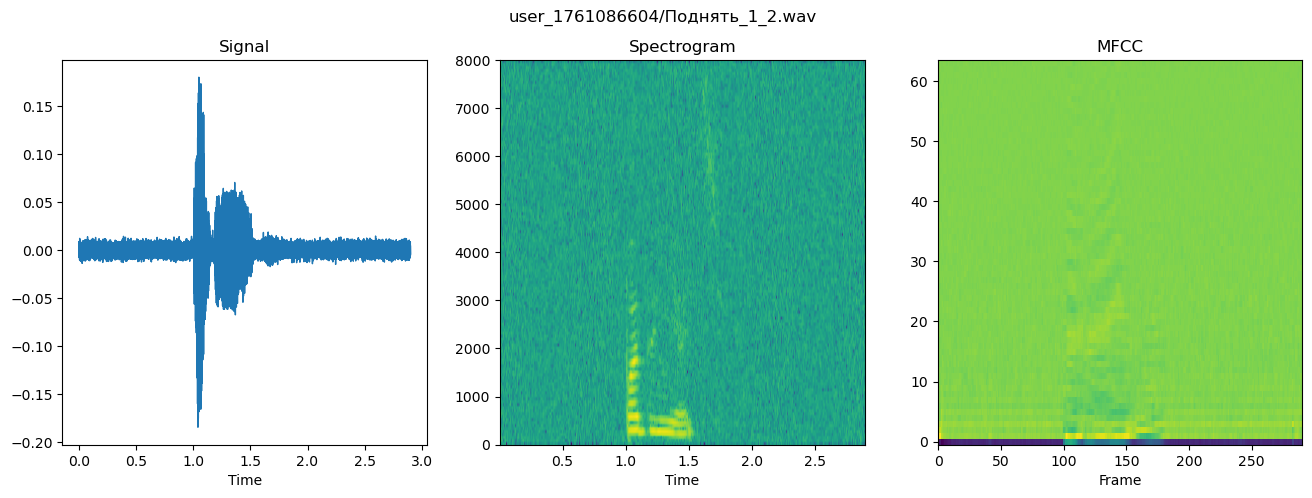

In [12]:
mfcc, label, signal, xname, label = next(c)
plot_waveform(signal, mfcc, sample_rate=16000, title=f'{xname}')
ipd.Audio(signal, rate=16000)

In [13]:
mfcc.shape

torch.Size([64, 291])

## Wandb data input

In [14]:
def create_plots(signal, feature_map, name_fig, sample_rate=16000, 
                            signal_plot_dir='signal_plots', 
                            spec_plot_dir='spec_plots', 
                            mfcc_plot_dir='mfcc_plots',
                            notebook_path='/kaggle/working/Voice-commands-recognition/notebooks'):
    
    signal = signal.numpy()

    num_frames = signal.size
    time_axis = torch.arange(0, num_frames) / sample_rate

    plt.plot(time_axis, signal, linewidth=1)
    plt.xlabel('Time')
    plt.title('Signal')
    plt.grid()
    plt.savefig(os.path.join(notebook_path, signal_plot_dir, name_fig))
    plt.clf()

    plt.specgram(signal, Fs=sample_rate)
    plt.xlabel('Time')
    plt.title('Spectrogram')
    plt.savefig(os.path.join(notebook_path, spec_plot_dir, name_fig))
    plt.clf()

    plt.imshow(feature_map, interpolation='nearest', origin='lower', aspect='auto')
    plt.xlabel('Frame')
    plt.title('MFCC')
    plt.savefig(os.path.join(notebook_path, mfcc_plot_dir, name_fig))
    plt.clf()
    

In [15]:
!ls /kaggle/working/Voice-commands-recognition/notebooks

'NN_rec copy.ipynb'   checkpoints   mfcc_plots	 signal_plots   spec_plots


In [16]:
# columns = ["name", "song_file", "signal_plot", "spec_plot", "mfcc_plot", "Label", "Set"]
# table = wandb.Table(columns=columns)

# signal_plot_dir='signal_plots'
# spec_plot_dir='spec_plots'
# mfcc_plot_dir='mfcc_plots'

# # for set_name, curr_data_set in data_set.items():
# #     print(set_name)
# for feature_map, idx_label, signal, name, label in tqdm(data_set['valid']):
#     name_fig = f'{name.replace("/", "_").split(".")[0]}.png'
#     create_plots(signal, feature_map, name_fig)    
#     temp = [name, 
#             wandb.Audio(signal, sample_rate=16000), 
#             wandb.Image(os.path.join( signal_plot_dir, name_fig )),
#             wandb.Image(os.path.join( spec_plot_dir, name_fig )),
#             wandb.Image(os.path.join( mfcc_plot_dir, name_fig )),
#             label, 'valid']
#     table.add_row(*temp)
#     # os.remove(os.path.join( signal_plot_dir, name_fig ))
#     # os.remove(os.path.join( spec_plot_dir, name_fig ))
#     # os.remove(os.path.join( mfcc_plot_dir, name_fig ))

# wandb.run.log({"songs" : table}) 

In [17]:
from models.model import Speech_recognition_model
import yaml

# Сделать разные конфиги
params = None
with open("/kaggle/working/Voice-commands-recognition/configs/model_params.yaml", "r") as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## Data Loader

In [19]:
def collate_fn(batch):
    X = torch.nn.utils.rnn.pad_sequence([sample[0].transpose(0, 1) for sample in batch], batch_first=True, padding_value=0).unsqueeze(1)
    y = torch.tensor([sample[1] for sample in batch])

    signal = [sample[2] for sample in batch]
    name = [sample[3] for sample in batch]
    label = [sample[4] for sample in batch]

    return X, y, signal, name, label

epochs, batch_size = params['Settings']['Other'].values()
loaders = {
            'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
            'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
            'test': torch.utils.data.DataLoader(data_set['test'], batch_size=1, shuffle=False, collate_fn=collate_fn)
          }

# Обучение и тестирование

## Wandb init

In [20]:
!wandb login --relogin 
wandb.init(project="Commands Recognition", name="pre_training_1", config=params)
columns = ["name", "song_file", "signal_plot", "spec_plot", "mfcc_plot", "pred_label", "true_label"]
valid_table = wandb.Table(columns=columns)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: litvan. Use `wandb login --relogin` to force relogin


In [21]:
lr_rate, weight_decay, amsgrad, max_lr, div_factor, max_norm = params['Settings']['Optimizer_Scheduler'].values()
model = Speech_recognition_model(**(params['Architecture']))
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),
                              lr=max_lr/div_factor,
                              weight_decay=weight_decay,
                              amsgrad=amsgrad)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                            steps_per_epoch=len(loaders['train']),
                            epochs=epochs, div_factor=div_factor)
model

Speech_recognition_model(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((32,

In [22]:
def get_accuracy(y_pred, y_test):
    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum/(y_test.size(0))
    
    return acc

In [23]:
signal_plot_dir = 'signal_plots'
spec_plot_dir = 'spec_plots'
mfcc_plot_dir = 'mfcc_plots'
notebook_path = '/kaggle/working/Voice-commands-recognition/notebooks'

def run_one_epoch(epoch, cross_valid=False, print_freq=1):
    start = time.time()
    total_loss = 0
    total_accuracy = 0

    data_loader = loaders['train'] if not cross_valid else loaders['valid']

    for i, (data) in enumerate(tqdm(data_loader)):
        feature_map, idx_label, signal, name, label = data
        input_data = feature_map.to(device)
        target_labels = idx_label.to(device)

        output_logits = model(input_data)
        loss = criterion(output_logits, target_labels)
        if not cross_valid:
            optimizer.zero_grad()
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                        max_norm)
            optimizer.step()

        total_loss += loss.item()
        pred_labels = torch.round(torch.sigmoid(output_logits)).type(torch.int8).argmax(1)
        accuracy = get_accuracy(pred_labels, target_labels)
        total_accuracy += accuracy
        optim_state = optimizer.state_dict()
        curr_lr = optim_state['param_groups'][0]['lr']
        
        if i % print_freq == 0:
                print('Epoch {0} | Iter {1} | Average Loss {2:.3f} | '
                      'Current Loss {3:.6f} | Current accuracy {4:.6f} | Current lr {5:.5f} | {6:.1f} ms/batch'.format(
                          epoch + 1, i + 1, total_loss / (i + 1),
                          loss.item(), accuracy, curr_lr, 1000 * (time.time() - start) / (i + 1)),
                      flush=True)

        if cross_valid:
            name_fig = f'{name[0].replace("/", "_").split(".")[0]}.png'
            create_plots(signal[0], feature_map[0][0], name_fig)    
            temp = [name[0], 
                wandb.Audio(signal[0], sample_rate=16000), 
                wandb.Image(os.path.join( notebook_path, signal_plot_dir, name_fig )),
                wandb.Image(os.path.join( notebook_path, spec_plot_dir, name_fig )),
                wandb.Image(os.path.join( notebook_path, mfcc_plot_dir, name_fig )),
                pred_labels[0],
                target_labels[0]]
            valid_table.add_row(*temp)
        
    return total_loss / (i + 1), total_accuracy / (i + 1)

In [24]:
torch.cuda.empty_cache()
gc.collect()

epoch = 0
checkpoint = False
visdom = True
save_folder = '/kaggle/working/Voice-commands-recognition/checkpoints'

tr_loss = []
cv_loss = []
tr_acc = []
cv_acc = []
best_val_loss = 0.1

wandb.watch(model, log_freq=1, log='all')
for epoch in tqdm(np.arange(epoch, epochs)):
    print("Training...")
    model.train()
    start = time.time()
    tr_avg_loss, tr_avg_acc = run_one_epoch(epoch)
    tr_loss.append(tr_avg_loss)
    tr_acc.append(tr_avg_acc)

    print('-' * 85)
    print('Train Summary | End of Epoch {0} | Time {1:.2f}s | '
                  'Train Loss {2:.3f} | Accuracy {3:.3f}'.format(
                      epoch + 1, time.time() - start, tr_avg_loss, tr_avg_acc))
    print('-' * 85)

    if checkpoint:
        file_path = os.path.join(
        save_folder, 'epoch_{0}_loss_{1:.4f}.pth.tar'.format(epoch + 1, cv_avg_loss))
        torch.save(model.serialize(model, optimizer, scheduler, epoch + 1,
                                        tr_loss=tr_loss,
                                        cv_loss=cv_loss),
                   file_path)
        print('Saving checkpoint model to %s' % file_path)

    print('Cross validation...')
    model.eval()  # Turn off Batchnorm & Dropout
    cv_avg_loss, cv_avg_acc = run_one_epoch(epoch, cross_valid=True)
    cv_loss.append(cv_avg_loss)
    cv_loss.append(cv_avg_acc)

    print('-' * 185)
    print('Valid Summary | End of Epoch {0} | Time {1:.2f}s | '
            'Valid Loss {2:.3f} | Accuracy {3:.3f}'.format(
                epoch + 1, time.time() - start, cv_avg_loss, cv_avg_acc))
    print('-' * 185)

    # Save the best model
    if cv_avg_loss < best_val_loss:
        best_val_loss = cv_avg_loss
        model_path = 'epoch_{0}_loss_{1:.4f}_best.pth.tar'.format(epoch + 1, cv_avg_loss)
        file_path = os.path.join(save_folder, model_path)
        torch.save(model.serialize(model, optimizer, scheduler, epoch + 1,
                                     tr_loss=tr_loss,
                                     cv_loss=cv_loss),
                 file_path)
        print("Find better validated model, saving to %s" % file_path)
    

    wandb.log({"epoch": epoch, "train_loss": tr_avg_loss})
    wandb.log({"epoch": epoch, "valid_loss": cv_avg_loss})
    wandb.log({"epoch": epoch, "train_accuracy": tr_avg_acc})
    wandb.log({"epoch": epoch, "valid_accuracy": cv_avg_acc})
    wandb.run.log({"valid_inference" : valid_table}) 

wandb.finish()
    

  0%|          | 0/10 [00:00<?, ?it/s]

Training...


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1 | Iter 1 | Average Loss 3.116 | Current Loss 3.116219 | Current accuracy 0.062500 | Current lr 0.00020 | 5331.0 ms/batch
Epoch 1 | Iter 2 | Average Loss 2.990 | Current Loss 2.863327 | Current accuracy 0.093750 | Current lr 0.00020 | 3646.1 ms/batch
Epoch 1 | Iter 3 | Average Loss 2.953 | Current Loss 2.878978 | Current accuracy 0.031250 | Current lr 0.00020 | 3085.7 ms/batch
Epoch 1 | Iter 4 | Average Loss 2.940 | Current Loss 2.902242 | Current accuracy 0.109375 | Current lr 0.00020 | 2801.4 ms/batch
Epoch 1 | Iter 5 | Average Loss 2.932 | Current Loss 2.898892 | Current accuracy 0.062500 | Current lr 0.00020 | 2625.0 ms/batch
Epoch 1 | Iter 6 | Average Loss 2.926 | Current Loss 2.898506 | Current accuracy 0.046875 | Current lr 0.00020 | 2503.3 ms/batch
Epoch 1 | Iter 7 | Average Loss 2.922 | Current Loss 2.898321 | Current accuracy 0.125000 | Current lr 0.00020 | 2429.5 ms/batch
Epoch 1 | Iter 8 | Average Loss 2.917 | Current Loss 2.882744 | Current accuracy 0.062500 | Curre

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1 | Iter 1 | Average Loss 2.324 | Current Loss 2.323843 | Current accuracy 0.140625 | Current lr 0.00020 | 1326.6 ms/batch


/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Epoch 1 | Iter 2 | Average Loss 2.328 | Current Loss 2.331240 | Current accuracy 0.109375 | Current lr 0.00020 | 1728.3 ms/batch
Epoch 1 | Iter 3 | Average Loss 2.293 | Current Loss 2.224698 | Current accuracy 0.078125 | Current lr 0.00020 | 1845.9 ms/batch
Epoch 1 | Iter 4 | Average Loss 2.250 | Current Loss 2.121308 | Current accuracy 0.109375 | Current lr 0.00020 | 1959.9 ms/batch
Epoch 1 | Iter 5 | Average Loss 2.214 | Current Loss 2.070384 | Current accuracy 0.140625 | Current lr 0.00020 | 2071.1 ms/batch
Epoch 1 | Iter 6 | Average Loss 2.192 | Current Loss 2.078429 | Current accuracy 0.093750 | Current lr 0.00020 | 2118.6 ms/batch
Epoch 1 | Iter 7 | Average Loss 2.177 | Current Loss 2.091896 | Current accuracy 0.062500 | Current lr 0.00020 | 2144.4 ms/batch
Epoch 1 | Iter 8 | Average Loss 2.185 | Current Loss 2.238839 | Current accuracy 0.109375 | Current lr 0.00020 | 2143.4 ms/batch
Epoch 1 | Iter 9 | Average Loss 2.193 | Current Loss 2.260736 | Current accuracy 0.109375 | Curre

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2 | Iter 1 | Average Loss 2.243 | Current Loss 2.242568 | Current accuracy 0.078125 | Current lr 0.00020 | 2134.1 ms/batch
Epoch 2 | Iter 2 | Average Loss 2.221 | Current Loss 2.199329 | Current accuracy 0.046875 | Current lr 0.00020 | 2034.8 ms/batch
Epoch 2 | Iter 3 | Average Loss 2.265 | Current Loss 2.352110 | Current accuracy 0.093750 | Current lr 0.00020 | 2020.3 ms/batch
Epoch 2 | Iter 4 | Average Loss 2.281 | Current Loss 2.330747 | Current accuracy 0.140625 | Current lr 0.00020 | 1974.1 ms/batch
Epoch 2 | Iter 5 | Average Loss 2.278 | Current Loss 2.263690 | Current accuracy 0.109375 | Current lr 0.00020 | 1983.0 ms/batch
Epoch 2 | Iter 6 | Average Loss 2.253 | Current Loss 2.128723 | Current accuracy 0.140625 | Current lr 0.00020 | 1962.7 ms/batch
Epoch 2 | Iter 7 | Average Loss 2.267 | Current Loss 2.351167 | Current accuracy 0.015625 | Current lr 0.00020 | 1952.5 ms/batch
Epoch 2 | Iter 8 | Average Loss 2.262 | Current Loss 2.228109 | Current accuracy 0.125000 | Curre

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2 | Iter 1 | Average Loss 1.552 | Current Loss 1.551882 | Current accuracy 0.046875 | Current lr 0.00020 | 1257.9 ms/batch
Epoch 2 | Iter 2 | Average Loss 1.608 | Current Loss 1.664851 | Current accuracy 0.031250 | Current lr 0.00020 | 1774.7 ms/batch
Epoch 2 | Iter 3 | Average Loss 1.582 | Current Loss 1.530049 | Current accuracy 0.078125 | Current lr 0.00020 | 1931.9 ms/batch
Epoch 2 | Iter 4 | Average Loss 1.564 | Current Loss 1.507305 | Current accuracy 0.093750 | Current lr 0.00020 | 1969.8 ms/batch
Epoch 2 | Iter 5 | Average Loss 1.578 | Current Loss 1.635566 | Current accuracy 0.140625 | Current lr 0.00020 | 2045.1 ms/batch
Epoch 2 | Iter 6 | Average Loss 1.575 | Current Loss 1.563012 | Current accuracy 0.078125 | Current lr 0.00020 | 2048.6 ms/batch
Epoch 2 | Iter 7 | Average Loss 1.559 | Current Loss 1.460355 | Current accuracy 0.078125 | Current lr 0.00020 | 2098.3 ms/batch
Epoch 2 | Iter 8 | Average Loss 1.544 | Current Loss 1.436800 | Current accuracy 0.140625 | Curre

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3 | Iter 1 | Average Loss 1.619 | Current Loss 1.619022 | Current accuracy 0.031250 | Current lr 0.00020 | 2000.1 ms/batch
Epoch 3 | Iter 2 | Average Loss 1.612 | Current Loss 1.605376 | Current accuracy 0.109375 | Current lr 0.00020 | 2085.5 ms/batch
Epoch 3 | Iter 3 | Average Loss 1.658 | Current Loss 1.749602 | Current accuracy 0.125000 | Current lr 0.00020 | 2039.0 ms/batch
Epoch 3 | Iter 4 | Average Loss 1.636 | Current Loss 1.568765 | Current accuracy 0.125000 | Current lr 0.00020 | 2043.1 ms/batch
Epoch 3 | Iter 5 | Average Loss 1.640 | Current Loss 1.658334 | Current accuracy 0.109375 | Current lr 0.00020 | 2010.1 ms/batch
Epoch 3 | Iter 6 | Average Loss 1.629 | Current Loss 1.571065 | Current accuracy 0.046875 | Current lr 0.00020 | 2036.9 ms/batch
Epoch 3 | Iter 7 | Average Loss 1.638 | Current Loss 1.690650 | Current accuracy 0.078125 | Current lr 0.00020 | 2041.1 ms/batch
Epoch 3 | Iter 8 | Average Loss 1.604 | Current Loss 1.369493 | Current accuracy 0.046875 | Curre

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
## Мысли насчет Wandb Sweep